In [1]:
%store -r Final_Data_Set_Nor
%store -r EN_Des
%store -r Data_Map
%store -r Sector_Des
%store -r Financial_Bert_Emb

import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable
from ipykernel import kernelapp as app
import scipy.stats as stats
import pylab as pl
from scipy.stats import norm
import statistics
import numpy.linalg as LA

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter

Using backend: pytorch


# Below Function Builds the Graph

In [77]:
def build_borrower_sector_graph(Data_Set):
    
    n_borrowers = len(Data_Set.keys())
    
    sector_list = set()
    for i in Data_Set.items():
        ID,data = i
        sector_list.add(data['Sector'])
    print(sector_list)
    sector_list = list(sector_list)
    n_sectors = len(sector_list)
    
    b_s_dst = []
    for i in Data_Set.items():
        ID,data = i
        b_s_dst.append(sector_list.index(data['Sector']))
    
    b_s_src = T.arange(n_borrowers,dtype=T.int64)
    b_s_dst = T.tensor(b_s_dst,dtype=T.int64)

    
    
    data_dict = {
    ('R&E', 'fin1', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE&TDE', 'fin2', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Description', 'text', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('R', 'R_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('E', 'E_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE', 'NDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('TDE', 'TDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Att_Description', 'text_att', 'Description' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('sector', 'belongs to', 'borrower'): (b_s_dst, b_s_src),
    ('Factor', 'effect', 'sector'): (T.arange(n_sectors), T.arange(n_sectors))
    }

    return dgl.heterograph(data_dict),n_borrowers,n_sectors, b_s_dst

G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Final_Data_Set_Nor)
print("No.of Borrowers ", n_borrowers, " No.of Sectors ", n_sectors)
%store sector_list

{'"325412"', '"511210"', '"2111"'}
No.of Borrowers  756  No.of Sectors  3
Stored 'sector_list' (Tensor)


In [3]:
def my_agg_func(tensors,dim, dsttype):
    p = len(tensors)
    a = 60
    w = 1/p

    X = []
    for i in range(p):
        l = []
        for j in range(p):
            if i == j:
                b = w
            else:
                b = a

            m1 = T.t(tensors[i]).detach().numpy()
            m2 = tensors[j].detach().numpy()
            
            shape = np.shape(np.matmul(m1,m2))
            padded_array = np.zeros((768, 768))
            padded_array[:shape[0],:shape[1]] = np.round(b*np.matmul(m1,m2),2)

            l.append(padded_array)
        X.append(np.concatenate(l,1))
    
    X = np.concatenate(X,0)

    w, v = LA.eig(X)
    
    W = w.copy()
    W.sort()
    W = W[::-1]
    top_ind = []
    for j in W[:dim]:
        top_ind.append(np.where(w == j)[0][0])
    
    Phi = 0
    eigenvect = []
    for i in top_ind:
        eigenvect.append(v[:,i])
    eigenvect = np.array(eigenvect)
    
    pro_vec = []
    n = 768
    for i in range(p):
        shape = tensors[i].shape
        V = eigenvect[: , n*i : n*(i+1)][: , 0:shape[1]]
        pro_vec.append(V)

    
    Phi = 0
    for i in range(p):
        Phi += np.matmul(tensors[i].detach().numpy(),np.transpose(pro_vec[i]))
    Phi = Phi/p
        
    return T.tensor(np.round(np.real(Phi),4),dtype=T.float32)

In [4]:
def my_conc_func(att1,att2):
    if len(att1) == len(att2):
        return T.cat((att1,att2),1)
    else:
        print("Tensors should be of same dimensions")
            

In [5]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# This is the Loss Function

'a' in the loss function is the average distance between the embeddings and their respective cluster centroids, whereas 'b' is the average distance between the cluster centroids.

In [60]:
def Loss_Function(embeddings, target_centers, centers, kmeans_labels):
    
    a = T.mean(T.sqrt(T.sum((embeddings - target_centers)**2,1)))
    
#     b = 0
#     n = 0
#     for center in centers:
#         for i in range(len(centers)):
#             b += T.sqrt(T.sum((center - centers[0])**2))
#             n += 1
    
#     b = b/(2*n)
    
    next_target = []
    for i in range(len(embeddings)):

        cluster = target_centers[i]
        
        if len(centers) != 1: 
            dist = []
            C = []
            for m in centers:
                d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
                dist.append(d)
                C.append(m)
                
            
            tup = list(zip(dist,C))
            lst = len(tup) 
            for i in range(0, lst): 

                for j in range(0, lst-i-1): 
                    if (tup[j][0] > tup[j + 1][0]): 
                        temp = tup[j] 
                        tup[j]= tup[j + 1] 
                        tup[j + 1]= temp
            
            next_c = tup[1][1]
        else:
            next_c = centers[0]
            
        
        next_target.append(next_c.detach().numpy())
    
    next_target = T.tensor(next_target)
    
    b = T.mean(T.sqrt(T.sum((embeddings - next_target)**2,1)))
    
    #print("Shil Score", (b - a)/T.max(a,b))
    
    return (a - b)/T.max(a,b)
    

# This is the Graph Neural Network


In [61]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_sector, out_sector, 'none',False, activation = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_RE, out_RE, 'none',False, activation = None, bias = False) for rel in L2_names}, aggregate='mean')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_NT, out_NT, 'none',False, activation = None, bias = False) for rel in L3_names}, aggregate='mean')
        self.conv4 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_Des, out_Des, 'none',False, activation = None, bias = False) for rel in L4_names}, aggregate='sum')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower,'none', activation = None,bias = False) for rel in L5_names},aggregate = 'sum')

    def forward(self, graph, inputs):
#         sector_inputs = {'Factor' : inputs['Factor'], 'sector' : inputs['sector'], 'borrower' : inputs['dummy_borrower']}
#         h_sector = self.conv1(graph, sector_inputs)
#         #h_sector = {k: F.relu(v) for k, v in h_sector.items()}
#         #print("Output", h_sector['sector'])
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        #h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        #print("R", inputs['R'], "E", inputs['E'],"R&E ", h_RE['R&E'].dtype)
        
        NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
        h_NT = self.conv3(graph, NT_inputs)
        #h_NT = {k: F.relu(v) for k, v in h_NT.items()}
        #print("NDE", inputs['NDE'], "TDE", inputs['TDE'],"NDE&TDE ", h_NT['NDE&TDE'])
        
        Des_inputs = {'Description' : inputs['Description'], 'Att_Description' : inputs['Att_Description'], 'borrower' : inputs['dummy_borrower']}
        h_Des = self.conv4(graph, Des_inputs)
        #h_Des = {k: F.leaky_relu(v) for k, v in h_Des.items()}
        #print("Description ", h_Des['Description'])
        
        E = my_agg_func([h_RE['R&E'],h_NT['NDE&TDE']],15,'borrower')
        #E = my_conc_func(h_RE['R&E'],h_NT['NDE&TDE'])
        
        borrower_inputs = {'borrower' : inputs['dummy_borrower'], 'R&E' : E}#,'sector' : h_sector['sector'], 'Description' : h_Des['Description']}
        
        h_borrower = self.conv5(graph, borrower_inputs)
        #h_borrower = {k: T.relu(v) for k, v in h_borrower.items()}
        #print("Borrower Embeddings ", h_borrower)
        
        return h_borrower
    

In [62]:
model = RGCN(5,5,5,5,768,768,768,768,15,15, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])

for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    E_Att = T.tensor([data['EBITDA']])
    NDE_Att = T.tensor([data['NDE']])
    TDE_Att = T.tensor([data['TDE']])
    #Des_Att = T.tensor(data['Description Embedding'])
    #sector_description = T.tensor(data['Description Embedding'])
    #Sec_Att = T.tensor(data['Description Embedding'])
    break
    
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.cat((R_Att,T.tensor([data['Revenue']])),0)
    E_Att = T.cat((E_Att,T.tensor([data['EBITDA']])),0)
    NDE_Att = T.cat((NDE_Att,T.tensor([data['NDE']])),0)
    TDE_Att = T.cat((TDE_Att,T.tensor([data['TDE']])),0)
    #Des_Att = T.cat((Des_Att,T.tensor(data['Description Embedding'])),0)
    #Sec_Att = T.cat((Sec_Att,T.tensor([Sector_Des[data['Sector'][1:-1]]['Sector Des Emb']])),0)
    
#Sec_Att = Sec_Att[1:]

# for i in Sector_Des.items():
#     ID,Emb = i
#     sector_description = T.cat((sector_description,T.tensor([Emb['Sector Des Emb']])),0)
    
    
G.nodes['borrower'].data['f'] = T.ones(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.ones(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.ones(n_borrowers,5)
G.nodes['Att_Description'].data['f'] = T.ones(n_borrowers,768)
G.nodes['Description'].data['f'] = T.ones(n_borrowers,768)
G.nodes['Factor'].data['f'] = T.ones(n_sectors,768)
G.nodes['sector'].data['f'] = T.ones(n_sectors,768)

# Training the graph using an unsupervised learning technique

Avg Node Cluster Distance of Cluster  0  is  7.0912046
Cluster  0  Center  [  1.9055648 -33.07602  ]
Avg Node Cluster Distance of Cluster  1  is  11.27894
Cluster  1  Center  [-3.9748042 26.62026  ]
Avg Node Cluster Distance of Cluster  2  is  8.376223
Cluster  2  Center  [ 18.082863 -15.026326]
Avg Node Cluster Distance of Cluster  3  is  13.593756
Cluster  3  Center  [-1.8361862 -2.3137186]
1   59.985207
2   24.238325
3   30.989027
0   59.985207
2   47.127262
3   29.012909
0   24.238325
1   47.127262
3   23.630043
0   30.989027
1   29.012909
2   23.630043


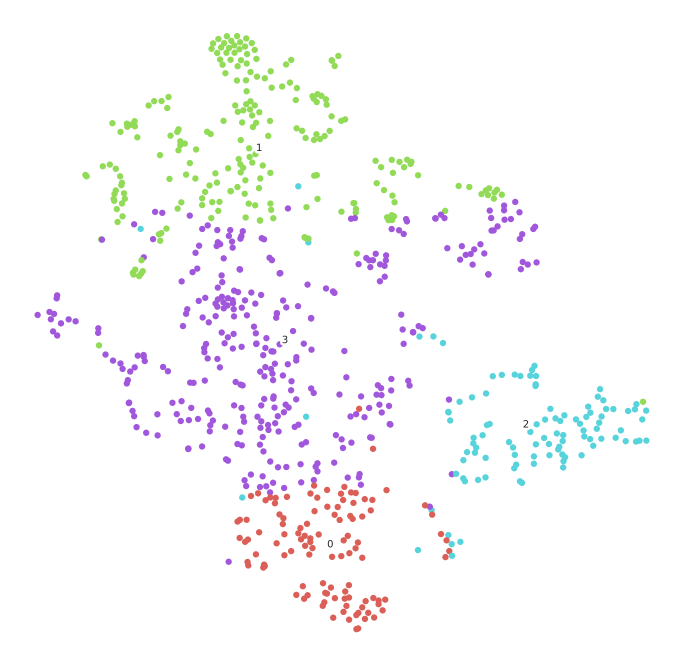

In [63]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
Des_feats = G.nodes['Description'].data['f']
Des_att_feats = G.nodes['Att_Description'].data['f']
factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.ones(n_borrowers,15)

node_features = {'borrower':borrower_feats,'sector':sector_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,
                 'Description':Des_feats,'Att_Description':Des_att_feats,'TDE':TDE_feats,'NDE&TDE': NT_feats,
                 'Factor':factor_feats,'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 4
Loss = []
epochs = 101
index = [i for i, n in enumerate(sector_list) if n == 0]
index2 = [i for i, n in enumerate(sector_list) if n == 1]
index3 = [i for i, n in enumerate(sector_list) if n == 2]

    
for epoch in range(epochs):
        
    model.train()                              # Forward Propogation
    logits = model(G, node_features)
    Borrower_Emb = logits['borrower'].detach().numpy()

    
    if epoch%25 == 0: 
        
        training_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(Borrower_Emb)    # K_Means Clustering
        centers = training_kmeans.cluster_centers_
        
        #TSNE before training
        if epoch == 0:
            fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
            fashion_scatter(fashion_tsne, training_kmeans.labels_)
        
        
        target_centers = []
        for i in Borrower_Emb:
            l = []
            for j in centers:
                mse = np.square(i - j).mean()
                l.append(mse)

            target_centers.append(l.index(min(l)))


        centers = T.tensor(centers)
        target_centers = centers[T.tensor(target_centers)]
    

    loss = Loss_Function(logits['borrower'], target_centers, centers, training_kmeans.labels_)     # Loss Calculation
    Loss.append(loss.tolist())

    
    opt.zero_grad()             # Back Propogation
    loss.backward()
    opt.step()
    


# training_labels = training_kmeans.labels_
# %store training_labels

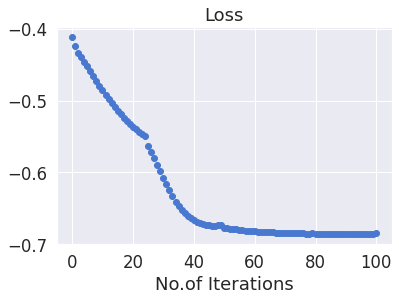

Avg Node Cluster Distance of Cluster  0  is  3.3896682
Cluster  0  Center  [-8.464975 28.318127]
Avg Node Cluster Distance of Cluster  1  is  10.898414
Cluster  1  Center  [-23.328642   6.399919]
Avg Node Cluster Distance of Cluster  2  is  15.961589
Cluster  2  Center  [  4.5858107 -19.262432 ]
Avg Node Cluster Distance of Cluster  3  is  8.1257305
Cluster  3  Center  [29.70309  16.429493]
1   26.482758
2   49.337944
3   39.976757
0   26.482758
2   37.917976
3   53.971813
0   49.337944
1   37.917976
3   43.643913
0   39.976757
1   53.971813
2   43.643913


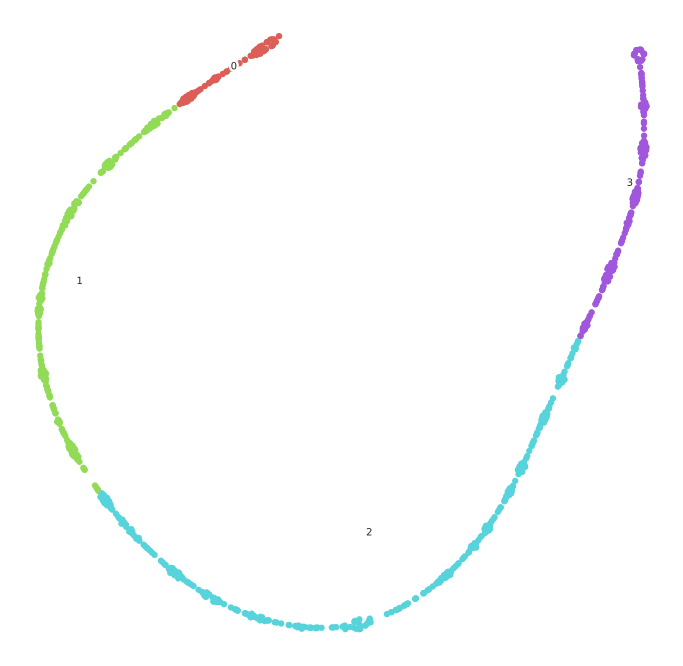

In [64]:
plt.scatter(list(range(len(Loss))),Loss)
plt.title("Loss")
plt.xlabel("No.of Iterations")
plt.show()

fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
fashion_scatter(fashion_tsne, training_kmeans.labels_)

In [65]:
def Print_Cluster(clusters,kmeans_labels):
    
    for i in range(clusters):

        cluster = np.where(kmeans_labels == i)[0]
        
        N = 0
        if len(cluster) < 5:
            l_N = len(cluster)
        else:
            l_N = 5
            
        n = 0
        score = 0
        print("\n","Cluster ",i, "of size ", len(cluster))
        for i in Final_Data_Set_Nor.items():
            ID,data = i

            if (n in cluster) and (N <= l_N):
                print(N,' ',data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
                #print(EN_Des[ID]['Description'],"\n")
                N += 1
            elif N > l_N:
                break
            n += 1
        
        score = score/len(cluster)

Print_Cluster(clusters,training_kmeans.labels_)


 Cluster  0 of size  66
0   [0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0, 0.1, 0.2, 0.2] [1.0, 1.0, 1.0, 0.9, 1.0] [0.86, 0.69, 0.68, 0.75, 0.8]
1   [0.9, 0.9, 0.8, 0.8, 0.8] [0.7, 0.7, 0.7, 0.7, 0.7] [1.0, 1.0, 0.8, 0, 0] [0.65, 0.61, 0.56, 0.78, 0.75]
2   [0.6, 0.6, 0.6, 0.6, 0.6] [0.5, 0.5, 0.5, 0.5, 0.5] [0, 0, 0.6, 0.9, 0.9] [0, 0.38, 0.88, 0.95, 0.94]
3   [0.9, 0.9, 0.9, 0.9, 0.9] [0.7, 0.7, 0.7, 0.7, 0.7] [0, 0.2, 0.5, 0.4, 0.2] [0.56, 0.75, 0.79, 0.78, 0.8]
4   [0.8, 0.8, 0.8, 0.8, 0.8] [0.7, 0.7, 0.7, 0.7, 0.7] [1.0, 0, 0, 1.0, 1.0] [0.75, 0.29, 0.89, 0.85, 0.64]
5   [0.5, 0.5, 0.5, 0.5, 0.4] [0.3, 0.2, 0.3, 0.3, 0.3] [0, 0, 0, 1.0, 1.0] [0.95, 0.95, 0.95, 0.95, 0.94]

 Cluster  1 of size  211
0   [0.6, 0.6, 0.6, 0.6, 0.5] [0.5, 0.6, 0.6, 0.5, 0] [0, 0, 0, 0, 0.7] [0, 0, 0.32, 0.43, 0.7]
1   [0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.1, 0.1] [0, 0, 0, 0.9, 0] [0.93, 0.85, 0.81, 0.8, 1.0]
2   [0.7, 0.7, 0.7, 0.7, 0.7] [0.7, 0.6, 0.6, 0.5, 0.5] [1.0, 1.0, 0.6, 0.1, 0] [0.61, 0.53, 0.45, 

In [66]:
def Metric(clusters,kmeans_labels):
    
    for j in range(clusters):

        cluster = np.where(kmeans_labels == j)[0]
            
        n = 0
        score = 0
        
        for i in Final_Data_Set_Nor.items():
            ID,data = i

            if (n in cluster):
                score += (np.array(data['Revenue']) + np.array(data['EBITDA']))/2

            n += 1
        
        score = np.mean(score)/len(cluster)
        print("\n","Cluster ",j, "of size ", len(cluster), "Score ",score)
    
Metric(clusters,training_kmeans.labels_)


 Cluster  0 of size  66 Score  0.613181818181818

 Cluster  1 of size  211 Score  0.36431279620853096

 Cluster  2 of size  320 Score  0.26690624999999973

 Cluster  3 of size  159 Score  0.1306918238993712


In [67]:
n = 0
for i in Borrower_Emb:
    print(i,"\n")
    n += 1
    if n == 5:
        break

[ 0.1003774  -0.10783581  0.18720585 -0.08772983 -0.06772786  0.12078584
 -0.05354479  0.18481024 -0.04865571 -0.10574196 -0.01823151 -0.04536063
 -0.14066693  0.08678987 -0.1202111 ] 

[ 0.13708057 -0.14726791  0.25652933 -0.12039908 -0.09237796  0.16564722
 -0.07300983  0.25423807 -0.06657406 -0.14499642 -0.02485705 -0.06180573
 -0.19218981  0.11824717 -0.16413927] 

[ 0.11081273 -0.11862275  0.2066744  -0.0975426  -0.07531843  0.1341326
 -0.0588574   0.20524694 -0.05411999 -0.11632466 -0.02030963 -0.05010453
 -0.15517697  0.09538583 -0.13291442] 

[ 0.09094542 -0.09762378  0.1694455  -0.07949611 -0.06115971  0.10931472
 -0.04839172  0.16732489 -0.04405666 -0.09571064 -0.016627   -0.04098041
 -0.1273642   0.07847197 -0.10891874] 

[ 0.11602023 -0.12404905  0.21617845 -0.10227656 -0.0791311   0.14072348
 -0.06163549  0.21506901 -0.05681544 -0.12158063 -0.02133841 -0.05250773
 -0.16233481  0.09979253 -0.13930565] 



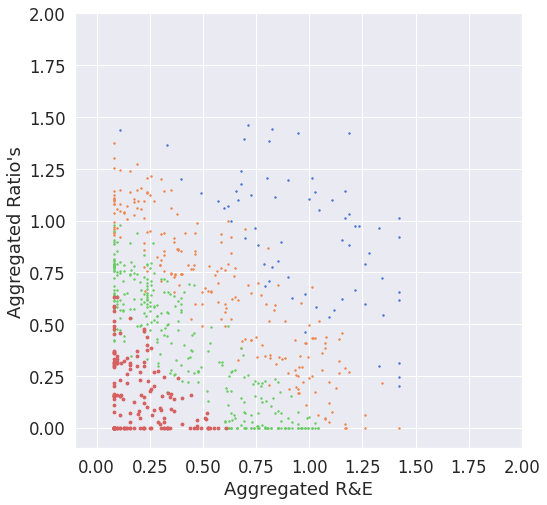

In [68]:
d = 1

Rev = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 0)[0]]
Net = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 0)[0]]

# for j in range(len(Rev)):
#     if (Rev[j][0].item() - Net[j][0].item() - 1.25 < 0):
#         print(j,np.where(training_kmeans.labels_ == 0)[0][j],' ',Rev[j][0],-Net[j][0])

Rev2 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 1)[0]]
Net2 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 1)[0]]

# for j in range(len(Rev2)):
#     if (Rev2[j][0].item() < 0.6) & (-Net2[j][0].item() < 0.6):
#         print(j,' ',Rev2[j][0],-Net2[j][0])

Rev3 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 2)[0]]
Net3 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 2)[0]]

# for j in range(len(Rev3)):
#     if (Rev3[j][0].item() - Net3[j][0].item() - 0.7 > 0):
#         print(j,np.where(training_kmeans.labels_ == 2)[0][j],' ',' ',Rev3[j][0],-Net3[j][0])

Rev4 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 3)[0]]
Net4 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 3)[0]]

plt.figure(figsize = (8,8))
plt.scatter(Rev,-Net,s = 2)
plt.scatter(Rev2,-Net2, s= 2)
plt.scatter(Rev3,-Net3, s = 2)
plt.scatter(Rev4,-Net4, s = 8)
plt.xlim(-0.1,2)
plt.ylim(-0.1,2)
plt.ylabel("Aggregated Ratio's")
plt.xlabel("Aggregated R&E")
plt.show()

In [69]:
Borrower_Emb_Dict = {}

n = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    Borrower_Emb_Dict[ID] = Borrower_Emb[n]
    n += 1

    
%store Borrower_Emb_Dict

Stored 'Borrower_Emb_Dict' (dict)


In [70]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
knn = NearestNeighbors(n_neighbors=10).fit(Borrower_Emb)

g = []
for p in range(n_borrowers):
    distances, indices = knn.kneighbors([Borrower_Emb[p]])

    indices[0].sort()
    #print("Borrower ",p," neighbors ",indices[0])

    n = 0
    l = []
    for i in Final_Data_Set_Nor.items():
        ID,data = i
        
        if n in indices[0]:
            for j in range(3):
                if n in np.where(training_kmeans.labels_ == j)[0]:
                    #print(n,'Cluster ',j,' ',data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
                    l.append(j)                   
        n += 1
    #print("\n")
        
    if all(element == l[0] for element in l):
        pass
    else:
        g.append(p)

for p in g:
    distances, indices = knn.kneighbors([Borrower_Emb[p]])

    indices[0].sort()
    print("Borrower ",p," neighbors ",indices[0])

    n = 0
    l = []
    for i in Final_Data_Set_Nor.items():
        ID,data = i
        
        if n in indices[0]:
            for j in range(3):
                if n in np.where(training_kmeans.labels_ == j)[0]:
                    print(n,'Cluster ',j,' ',data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
                    l.append(j)                   
        n += 1
    print("\n")

Borrower  223  neighbors  [190 223 243 377 442 600 673 683 727 729]
190 Cluster  2   [0.7, 0.7, 0.7, 0.7, 0.7] [0.6, 0.6, 0.7, 0.6, 0.5] [0, 0, 0, 0, 0] [0, 0.0, 0.12, 0, 0]
223 Cluster  2   [0.3, 0.3, 0.3, 0.2, 0.3] [0, 0, 0, 0, 0.3] [1.0, 1.0, 0, 0.0, 1.0] [0, 0.8, 1.0, 0.83, 0]
243 Cluster  2   [0.3, 0.3, 0.3, 0.3, 0.2] [0, 0.1, 0.1, 0, 0] [0, 0, 0, 0, 0.4] [0.99, 0.97, 0.93, 0.88, 0.88]
377 Cluster  2   [0.3, 0.3, 0.2, 0.1, 0.1] [0, 0.1, 0, 0, 0] [0, 0, 1.0, 1.0, 0.9] [0, 0, 0, 1.0, 0]
442 Cluster  1   [0.1, 0.3, 0.3, 0.3, 0.3] [0, 0, 0, 0.1, 0] [0, 0, 0.8, 0, 0] [1.0, 0.99, 0.87, 0.98, 0.8]
600 Cluster  2   [0.7, 0.7, 0.7, 0.7, 0.7] [0.6, 0.6, 0.6, 0.5, 0.5] [0, 0, 0, 0, 0] [0.22, 0.14, 0, 0, 0]
673 Cluster  2   [0.6, 0.6, 0.6, 0.6, 0.6] [0.5, 0.4, 0.4, 0.4, 0.3] [0, 0, 0, 0, 0] [0.1, 0.24, 0.28, 0.46, 0.3]
683 Cluster  2   [0.7, 0.7, 0.7, 0.7, 0.7] [0.6, 0.7, 0.7, 0.7, 0] [0, 0, 0, 0, 0] [0, 0.27, 0.02, 0, 0]
727 Cluster  2   [0.5, 0.5, 0.5, 0.5, 0.5] [0.4, 0.4, 0.3, 0, 0.3] [0, 

In [71]:
M = []
for h in range(10,50):
    H = []
    KNN = NearestNeighbors(n_neighbors=h).fit(Borrower_Emb)

    for p in range(n_borrowers):
        distances, indices = KNN.kneighbors([Borrower_Emb[p]])

        indices[0].sort()
        #print("Borrower ",p," neighbors ",indices[0])

        n = 0
        l = []
        for i in Final_Data_Set_Nor.items():
            ID,data = i

            if n in indices[0]:
                for j in range(3):
                    if n in np.where(training_kmeans.labels_ == j)[0]:
                        l.append(j)                   
            n += 1

        if all(element == l[0] for element in l):
            pass
        else:
            H.append(p)
            
    M.append(len(H)/756)

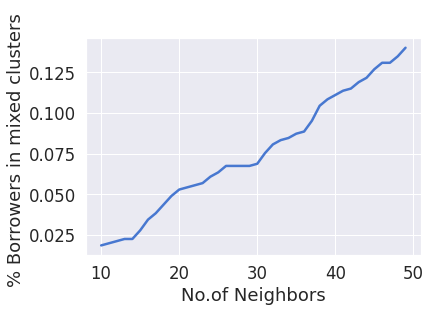

In [72]:
plt.plot(np.arange(10,50),M)
plt.xlabel("No.of Neighbors")
plt.ylabel("% Borrowers in mixed clusters ")
plt.show()

# Borrower Embeddings with respect to clusters 

In [19]:
# #Borrower Embeddings of each cluster
# for i in range(clusters):
#     print("Cluster ", i)
#     print(Borrower_Emb[np.where(training_kmeans.labels_ == i)[0]][:5],"\n")



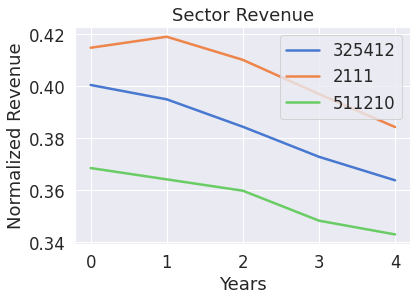

In [73]:
sector_rev_3 = np.array([0.,0.,0.,0.,0.])
sector_rev_2 = np.array([0.,0.,0.,0.,0.])
sector_rev_5 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
for i in Final_Data_Set_Nor.items():
    ID, data = i
    if data['Sector'][1:-1] == "325412":
        sector_rev_3 += np.array(data['Revenue'])
        n += 1
    elif data['Sector'][1:-1] == "2111":
        sector_rev_2 += np.array(data['Revenue'])
        m += 1
    elif data['Sector'][1:-1] == "511210":
        sector_rev_5 += np.array(data['Revenue'])
        p += 1
    
        
sector_rev_3 = sector_rev_3/n
sector_rev_2 = sector_rev_2/m
sector_rev_5 = sector_rev_5/p
p1, = plt.plot(range(len(sector_rev_3)),sector_rev_3)
p2, = plt.plot(range(len(sector_rev_2)),sector_rev_2)
p3, = plt.plot(range(len(sector_rev_5)),sector_rev_5)
plt.legend([p1,p2,p3],['325412', '2111', '511210'])
plt.xlabel("Years")
plt.ylabel("Normalized Revenue")
plt.title("Sector Revenue")
plt.show()

113 42 44


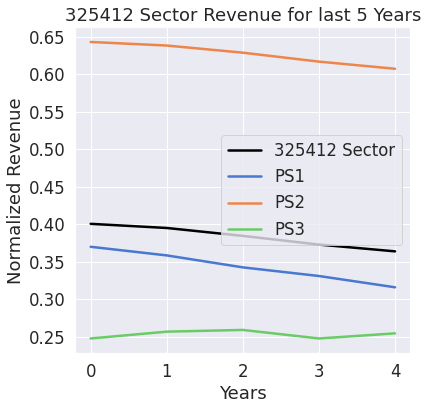

Avg Node Cluster Distance of Cluster  0  is  5.956501
Cluster  0  Center  [ 0.8989757 -1.9370338]
Avg Node Cluster Distance of Cluster  1  is  1.774835
Cluster  1  Center  [  5.078843 -17.254648]
Avg Node Cluster Distance of Cluster  2  is  2.0280745
Cluster  2  Center  [-5.111977 13.099481]
1   15.877677
2   16.193464
0   15.877677
2   32.01915
0   16.193464
1   32.01915


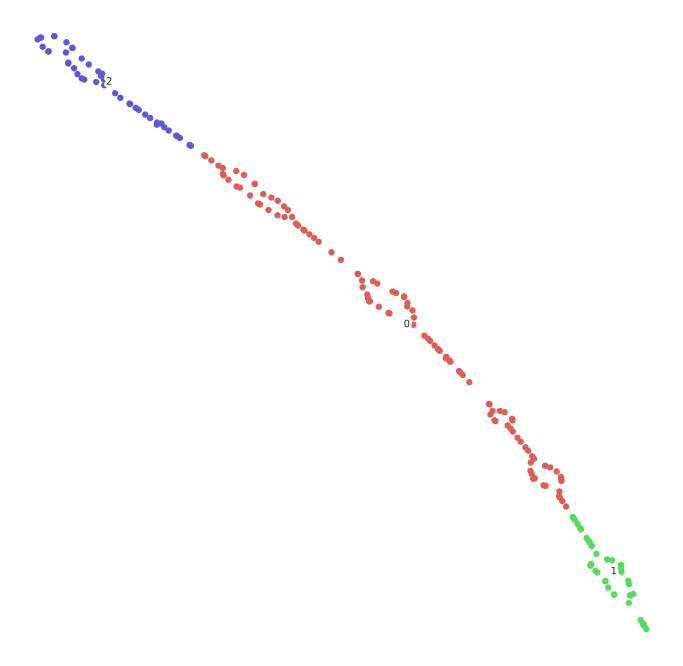

In [74]:
X_1 = logits['borrower'].detach().numpy()[index]
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(X_1)

PS1_1 = []
PS2_1 = []
PS3_1 = []

for i in list(zip(index,kmeans_1.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_1.append(ind)
    elif ps == 1:
        PS2_1.append(ind)
    elif ps == 2:
        PS3_1.append(ind)
        
Psector1_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_1 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_1 += np.array(data['Revenue'])
        m += 1
    if n in PS2_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector2_rev_1 += np.array(data['Revenue'])
        p += 1
    if n in PS3_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector3_rev_1 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_1 = Psector1_rev_1/m
Psector2_rev_1 = Psector2_rev_1/p
Psector3_rev_1 = Psector3_rev_1/q
print(m,p,q)

plt.figure(figsize = (6,6))
S, = plt.plot(range(len(sector_rev_3)),sector_rev_3,'k')
ps1, = plt.plot(range(len(Psector1_rev_1)),Psector1_rev_1)
ps2, = plt.plot(range(len(Psector2_rev_1)),Psector2_rev_1)
ps3, = plt.plot(range(len(Psector3_rev_1)),Psector3_rev_1)
plt.legend([S,ps1,ps2,ps3],['325412 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("325412 Sector Revenue for last 5 Years")
plt.xlabel("Years")
plt.ylabel("Normalized Revenue")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_1)
fashion_scatter(fashion_tsne, kmeans_1.labels_)

177 53 91


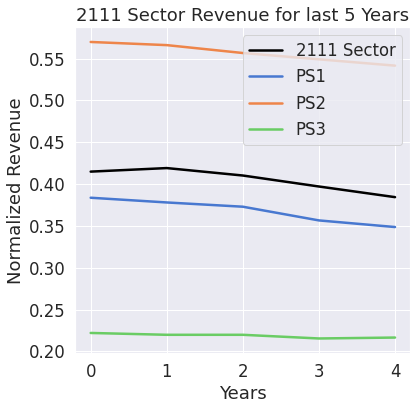

Avg Node Cluster Distance of Cluster  0  is  9.342449
Cluster  0  Center  [-6.403034  -4.8148513]
Avg Node Cluster Distance of Cluster  1  is  2.5898187
Cluster  1  Center  [ 10.356828 -19.984531]
Avg Node Cluster Distance of Cluster  2  is  4.5951138
Cluster  2  Center  [-4.0600433 19.925566 ]
1   22.605577
2   24.851114
0   22.605577
2   42.434208
0   24.851114
1   42.434208


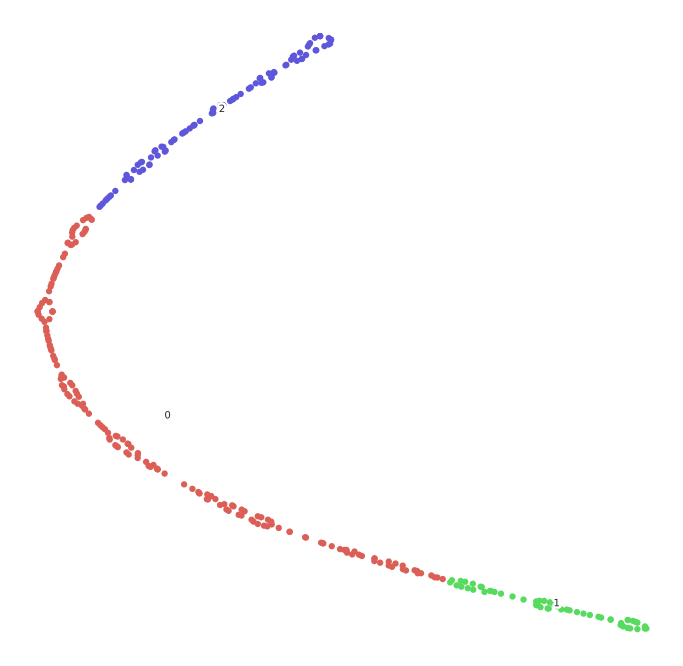

In [75]:
X_2 = logits['borrower'].detach().numpy()[index2]
kmeans_2 = KMeans(n_clusters=3, random_state=0).fit(X_2)

PS1_2 = []
PS2_2 = []
PS3_2 = []

for i in list(zip(index2,kmeans_2.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_2.append(ind)
    elif ps == 1:
        PS2_2.append(ind)
    elif ps == 2:
        PS3_2.append(ind)
        
Psector1_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_2 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_2:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_2 += np.array(data['Revenue'])
        m += 1
    if n in PS2_2:
        Psector2_rev_2 += np.array(data['Revenue'])
        p += 1
    if n in PS3_2:
        Psector3_rev_2 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_2 = Psector1_rev_2/m
Psector2_rev_2 = Psector2_rev_2/p
Psector3_rev_2 = Psector3_rev_2/q
print(m,p,q)

plt.figure(figsize = (6,6))
S, = plt.plot(range(len(sector_rev_2)),sector_rev_2,'k')
ps1, = plt.plot(range(len(Psector1_rev_2)),Psector1_rev_2)
ps2, = plt.plot(range(len(Psector2_rev_2)),Psector2_rev_2)
ps3, = plt.plot(range(len(Psector3_rev_2)),Psector3_rev_2)
plt.legend([S,ps1,ps2,ps3],['2111 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("2111 Sector Revenue for last 5 Years")
plt.xlabel("Years")
plt.ylabel("Normalized Revenue")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_2)
fashion_scatter(fashion_tsne, kmeans_2.labels_)

107 81 48


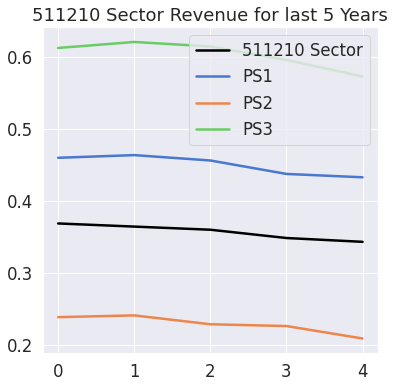

Avg Node Cluster Distance of Cluster  0  is  5.715549
Cluster  0  Center  [ 2.122891  -3.2455657]
Avg Node Cluster Distance of Cluster  1  is  3.8830974
Cluster  1  Center  [ 3.8448095 16.203222 ]
Avg Node Cluster Distance of Cluster  2  is  2.1790345
Cluster  2  Center  [ -0.9896994 -18.711258 ]
1   19.524864
2   15.7758
0   19.524864
2   35.247604
0   15.7758
1   35.247604


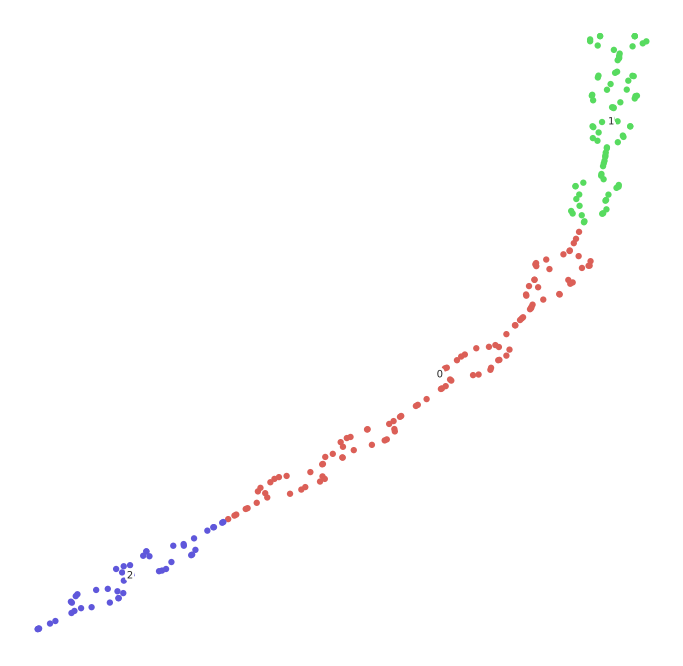

In [23]:
X_3 = logits['borrower'].detach().numpy()[index3]
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X_3)

PS1_3 = []
PS2_3 = []
PS3_3 = []

for i in list(zip(index3,kmeans_3.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_3.append(ind)
    elif ps == 1:
        PS2_3.append(ind)
    elif ps == 2:
        PS3_3.append(ind)
        
Psector1_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_3 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_3:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_3 += np.array(data['Revenue'])
        m += 1
    if n in PS2_3:
        Psector2_rev_3 += np.array(data['Revenue'])
        p += 1
    if n in PS3_3:
        Psector3_rev_3 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_3 = Psector1_rev_3/m
Psector2_rev_3 = Psector2_rev_3/p
Psector3_rev_3 = Psector3_rev_3/q
print(m,p,q)

plt.figure(figsize = (6,6))
S, = plt.plot(range(len(sector_rev_5)),sector_rev_5,'k')
ps1, = plt.plot(range(len(Psector1_rev_3)),Psector1_rev_3)
ps2, = plt.plot(range(len(Psector2_rev_3)),Psector2_rev_3)
ps3, = plt.plot(range(len(Psector3_rev_3)),Psector3_rev_3)
plt.legend([S,ps1,ps2,ps3],['511210 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("511210 Sector Revenue for last 5 Years")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_3)
fashion_scatter(fashion_tsne, kmeans_3.labels_)

In [24]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(5, 5, bias = False)

    def forward(self, x):
        
        x = self.l1(x)
        
        return x


net = Net()
print(net)

input = T.randn(5)
print(input)
out = net(input)
print(out)

Net(
  (l1): Linear(in_features=5, out_features=5, bias=False)
)
tensor([ 0.8177,  0.3502,  1.1766,  0.3811, -0.3877])
tensor([ 0.3469,  0.4444,  0.5683, -0.0466,  0.0998],
       grad_fn=<SqueezeBackward3>)


In [25]:
g = dgl.heterograph({
    ('user', 'follows', 'user') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('user', 'plays', 'game') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('store', 'sells', 'game')  : (T.tensor([0,1,2]),T.tensor([0,1,2]))})

In [26]:
import dgl.nn.pytorch as dglnn
conv = dglnn.HeteroGraphConv({
    'follows' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'plays' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'sells' : dglnn.SAGEConv(3,3, 'mean', norm = None,weight = False, activation = None, bias = False)}, aggregate='sum')

TypeError: __init__() got an unexpected keyword argument 'weight'

In [ ]:
h1 = {'user' : T.rand(g.number_of_nodes('user'), 3), 'game' : T.ones(g.number_of_nodes('game'), 3)}
h11 = {'store' : T.rand(g.number_of_nodes('store'),3), 'game' : T.zeros(g.number_of_nodes('game'), 3)}
print(h1)
h2 = conv(g, h1)
print(h2)

In [ ]:
    H = {'0':[],'1':[],'2':[]}
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    for n in range(clusters):
        for i in np.where(training_kmeans.labels_ == n)[0]:
            for (j,k) in zip(Final_Data_Set_Nor[Data_Map[i]]['NDE'],Final_Data_Set_Nor[Data_Map[i]]['TDE']):
                H[str(n)].append(max(j,k))
    H['0'].sort()
    H['1'].sort()
    H['2'].sort()
    fit1 = stats.norm.pdf(H['0'], np.mean(H['0']), np.std(H['0'])) 
    fit2 = stats.norm.pdf(H['1'], np.mean(H['1']), np.std(H['1']))
    fit3 = stats.norm.pdf(H['2'], np.mean(H['2']), np.std(H['2']))
    ax1.plot(H['0'],fit1)
    ax2.plot(H['1'],fit2)
    ax3.plot(H['2'],fit3)
    plt.show()

In [ ]:
#     next_target = []
#     for i in range(len(embeddings)):

#         cluster = target_centers[i]
        
#         if len(centers) != 1: 
#             dist = []
#             C = []
#             for m in centers:
#                 d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
#                 dist.append(d)
#                 C.append(m)
                
            
#             tup = list(zip(dist,C))
#             lst = len(tup) 
#             for i in range(0, lst): 

#                 for j in range(0, lst-i-1): 
#                     if (tup[j][0] > tup[j + 1][0]): 
#                         temp = tup[j] 
#                         tup[j]= tup[j + 1] 
#                         tup[j + 1]= temp
            
#             next_c = tup[1][1]
#         else:
#             next_c = centers[0]
            
        
#         next_target.append(next_c.detach().numpy())
    
#     next_target = T.tensor(next_target)
    
    #b = T.sqrt(T.sum((embeddings - next_target)**2,1))